In [1]:
from functools import partial
# import sys
# sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt

import KBio


In [2]:
p = KBio.Polynomial(degree = 2, c=1)

We'll run our simulation with a time step (Euler method) of 0.01, 5% initial infection (this is quite high, but avoids stability issues **and** makes for way more awesome plots).

In [3]:
beta = 4e-3
gamma = 1e-3
T_final = 6e1
dt = 1e-2  # for Euler step
data = KBio.rectangular_grid([0], [6e1], [60 + 1])
sim = KBio.SIS_sim(dt=dt, T_final=T_final, beta=beta, gamma=gamma, I0 = 5, S0 = 95)
sim(data, forcing = lambda x: 1.8e-4*np.sin(0.01 + 0.4*x))

0


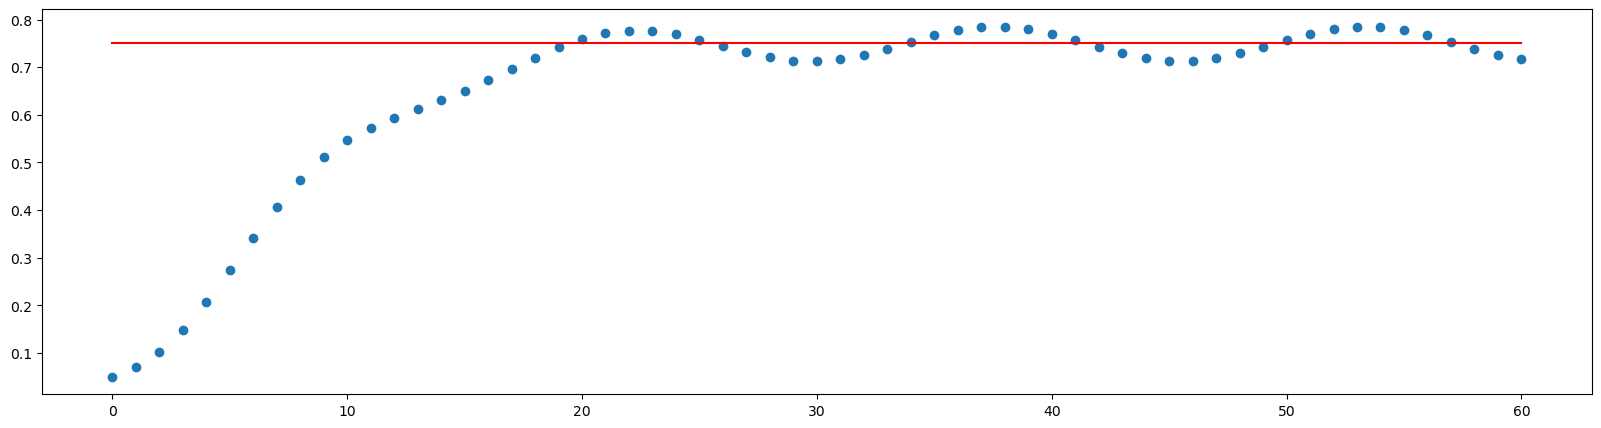

In [4]:
plt.figure(figsize=(20,5))
plt.plot(data.grid_tensors[0], data.grid_tensors_values, 'o')
# Put a vertical line at asymptotic steady state under no perturbation
steady_state = sim.asymptotic_steady_state() # 1 - 1/R0
# horizontal line from 0 to T_max at the asymptotic steady state
plt.plot([0, np.max(data.grid_tensors[0])], [steady_state, steady_state], 'r')

Now let's generate a small data set of 200 points, with 40 trajectories, and plot it. We'll sample the forcing functions as sinusoids with random frequencies and amplitudes, and constants. 80 trajectories will be with sinusoidal forcing, and 20 will be constant.

In [5]:
def oscillatory_forcing(A, omega, phi, t):
    return A*np.sin(omega + phi*t) * np.minimum(1, t/10)

def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [6]:
n_samples_oscillatory = 5
# use log-uniform distribution to generate amplitudes
amplitudes = 10 ** (np.random.uniform(-3, -2.5, n_samples_oscillatory))

# use uniform distribution to generate frequencies
shifts = np.random.uniform(0, np.pi, n_samples_oscillatory)
print(shifts)
frequencies = np.random.uniform(1, 6, n_samples_oscillatory)
forcing_functions = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, frequency in zip(amplitudes, shifts, frequencies)]
grids_oscillatory = [KBio.rectangular_grid([0], [60], [61]) for _ in range(n_samples_oscillatory)]
for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory, amplitudes, shifts, frequencies, forcing_functions):
    sim(grid, forcing = fn)

[1.40427043 2.93052292 1.48060751 0.67373098 1.82188254]


0
0
0
0
0


Our oscillatory forcing function is of the form
$$
f(t) = \min(1, t / 10) A \sin(\omega t + \phi)
$$

So by day 10, the forcing function will be at its full amplitude. This avoids issues where the forcing function overpowers the dynamics of the system and makes the trajectories non-physical. 

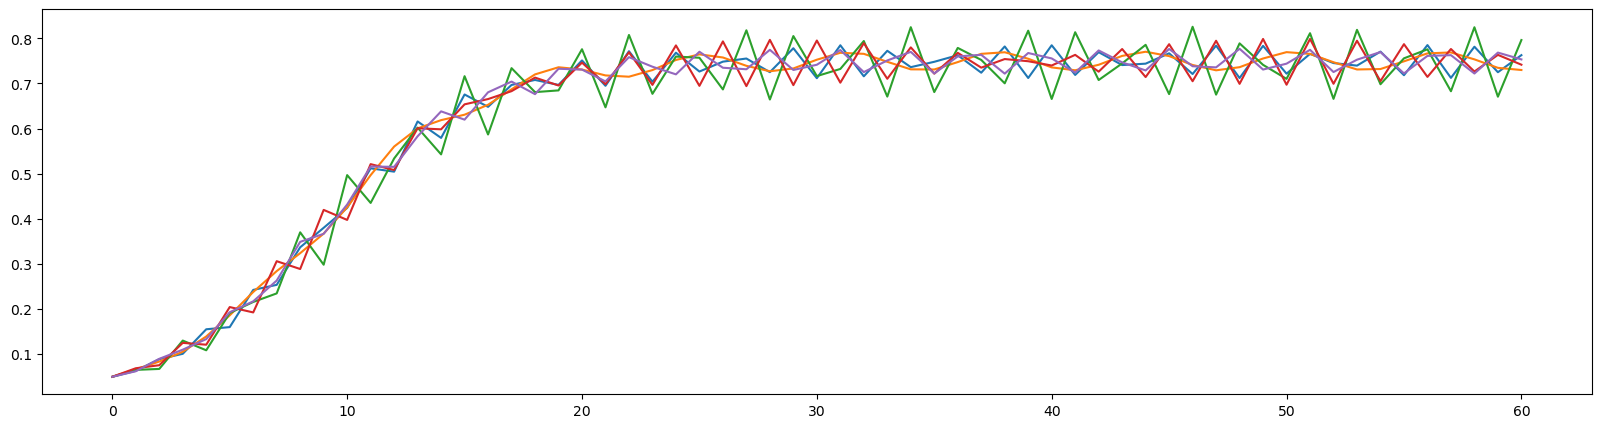

In [7]:
plt.figure(figsize=(20,5))
for grid in grids_oscillatory:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [8]:
n_samples_constant = 5
grids_constant = [KBio.rectangular_grid([0], [60], [61]) for _ in range(n_samples_constant)]

constant_values = np.random.normal(0, 1e-4, n_samples_constant)
functions_constant = [partial(constant_forcing, constant_value) for constant_value in constant_values]
for grid, constant_value, fn in zip(grids_constant, constant_values, functions_constant):
    sim(grid, forcing = fn)

0
0
0
0
0


In [9]:
constant_values

array([-1.72226513e-04,  3.91684002e-06, -5.04061858e-05,  1.75946086e-05,
        3.92807595e-05])

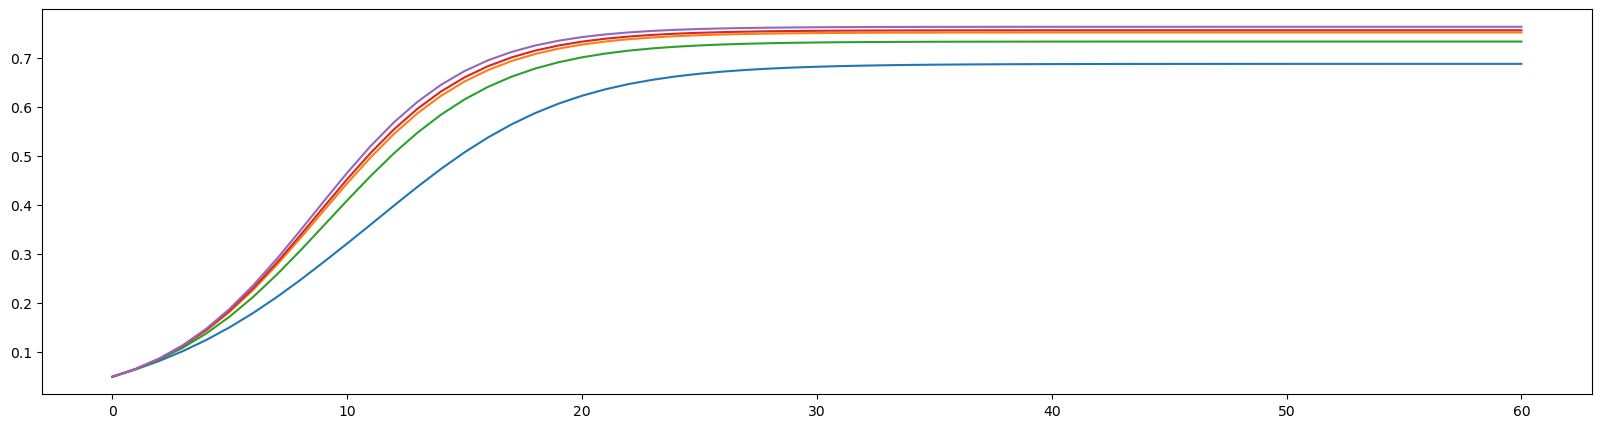

In [10]:
plt.figure(figsize=(20,5))
for grid in grids_constant:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [11]:
grids_all = grids_oscillatory + grids_constant


In [12]:
# Reformat the data into a format that can be used by the Kernel
smoothed_data = []
smoothed_derivatives = []
alphas_list = [[0], [1]]
x_data = np.stack([grid.grid_tensors[0] for grid in grids_all])
y_data = np.stack([grid.grid_tensors_values for grid in grids_all])
f_data = np.stack([grid.grid_tensors_forcing for grid in grids_all])

u_smoothed = KBio.kernel_smoothing(p, x_grid = x_data, u_data = y_data, f_data = f_data, alpha_list=alphas_list)
u_smoothed
# for grid in grids_all:
#     s = KBio.kernel_smoothing(p, x_grid = grid.grid_tensors[0], u_data = grid.grid_tensors_values, f_data = grid.grid_tensors_forcing, alpha_list=alphas_list[0])
#     smoothed_data.append(s)
#     s2 = KBio.kernel_smoothing(p, x_grid = grid.grid_tensors[0], y_grid = grid.grid_tensors_values, f_data = grid.grid_tensors_forcing, alpha_list=alphas_list[1])
    # smoothed_derivatives.append(s2)

alpha [0]
Alphas
[0]
(1,)
Reshaped alphas
(1, 1)
Reshaped x
Reshaped y


ValueError: shapes (61,) and (1,61) not aligned: 61 (dim 0) != 1 (dim 0)

In [13]:

alphas = np.asarray(alphas_list[0])
print(alphas.shape)
if len(alphas.shape) == 1:
    alphas = alphas.reshape((1, -1))
print(alphas.shape)
print(alphas)

(1,)
(1, 1)
[[0]]


In [14]:
xp_data = p.multiDerivative(x_data, y=y_data, alpha=alphas)

alpha [[0]]
Alphas
[[0]]
(1, 1)


ValueError: shapes (61,) and (10,61) not aligned: 61 (dim 0) != 10 (dim 0)

In [15]:
d = np.zeros(x_data.shape)

In [19]:
d[0].shape

(61,)

In [ ]:
x_data.shape

(10, 200)

In [ ]:
y_data.shape

(10, 200)

In [ ]:
f_data.shape

(10, 200)